In [20]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
npz_path = r'F:\treadmill_gaze_control\recordings\230316_DMM_DMM001_eyecams\R01\230316_DMM001_R01_s2pData.npz'
npz_data = np.load(npz_path, allow_pickle=True)

In [9]:
list(data.keys())

['F', 'Fneu', 'spks', 'stat', 'ops', 'iscell']

In [18]:
data = {
    'stat': npz_data['stat'],
    'ops': npz_data['ops'].item(),
    'F': npz_data['F'],
    'Fneu': npz_data['Fneu'],
    'iscell': npz_data['iscell'],
    'spks': npz_data['spks']
}

In [80]:
inds = np.arange(np.size(data['iscell'],0))
goodcells = inds[data['iscell'][:,0]==1]

data['F0'] = np.zeros(len(inds))*np.nan
for n in inds:
    hist, bins = np.histogram(data['F'][n,:], bins=150)
    data['F0'][n] = bins[np.nanargmax(hist)]

cellstats = {
    'prob': np.zeros(len(inds))*np.nan,
    'rad': np.zeros(len(inds))*np.nan,
    'aspect': np.zeros(len(inds))*np.nan,
    'cmpt': np.zeros(len(inds))*np.nan,
    'std': np.zeros(len(inds))*np.nan,
    'ovrlap': np.zeros(len(inds))*np.nan,
    'snr': np.zeros(len(inds))*np.nan,
    'auto_label': np.zeros(len(inds))*np.nan,
    'hand_label': np.zeros(len(inds))*np.nan,
    'hand_label_iters': {}
}

data['Fsub'] = np.empty(data['F'].shape)*np.nan

for n in tqdm(inds):
    cellstats['prob'][n] = data['iscell'][n][1]
    cellstats['rad'][n] = data['stat'][n]['radius']
    cellstats['aspect'][n] = data['stat'][n]['aspect_ratio']
    cellstats['cmpt'][n] = (1/data['stat'][n]['compact'])*100
    cellstats['std'][n] = data['stat'][n]['std']
    cellstats['ovrlap'][n] = np.sum(data['stat'][n]['overlap']) / len(data['stat'][n]['overlap'])
    cellstats['snr'][n] = np.median(data['F'][n,:] / data['F0'][n])

    data['Fsub'][n,:] = data['F'][n,:].copy() - data['Fneu'][n,:].copy()

  0%|          | 0/4083 [00:00<?, ?it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_32884\148885468.py:31: RuntimeWarning: invalid value encountered in divide
  cellstats['snr'][n] = np.median(data['F'][n,:] / data['F0'][n])
100%|██████████| 4083/4083 [00:00<00:00, 12741.58it/s]


(0.5, 1.5)

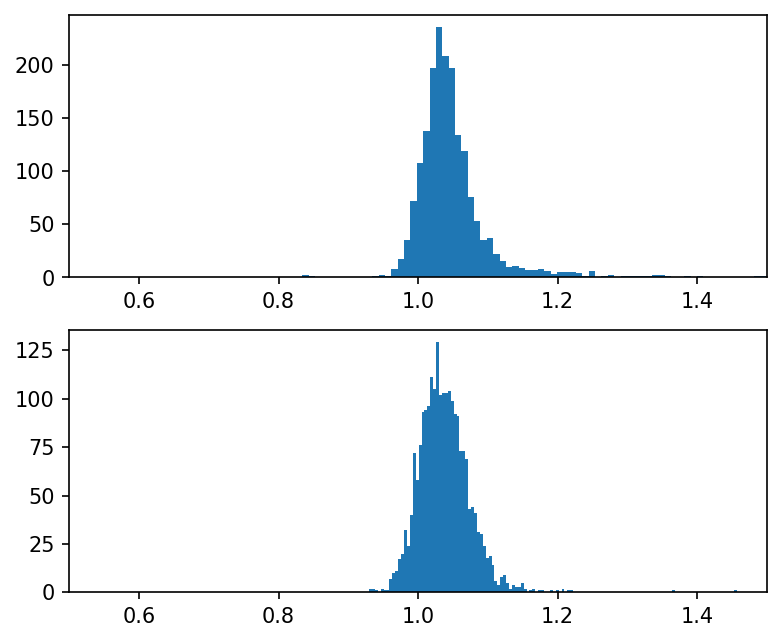

In [75]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(6,5), dpi=150)
ax1.hist(cellstats['snr'][goodcells], bins=150)
ax2.hist(cellstats['snr'][inds[data['iscell'][:,0]==0]], bins=150)

ax1.set_xlim([0.5,1.5])
ax2.set_xlim([0.5,1.5])

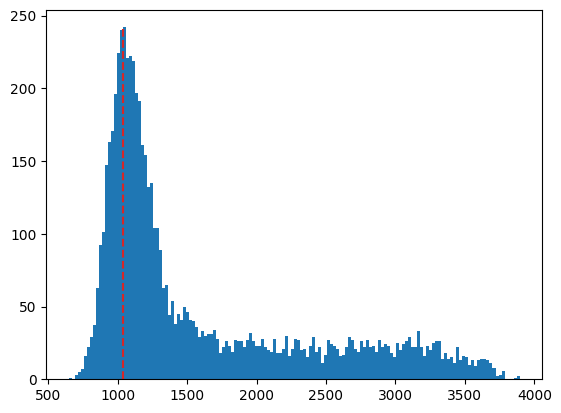

In [53]:
hist = plt.hist(data['F'][0,:], bins=150)
plt.vlines(hist[1][np.argmax(hist[0])], 0, np.max(hist[0]), color='tab:red', linestyle='--')

In [83]:
inds[np.isnan(cellstats['snr'])]

array([ 212,  423,  744,  828,  980, 1158, 1987, 2084, 2182, 2276, 2346,
       2441, 2589, 2590, 2672, 3085, 3129, 3445, 3973])

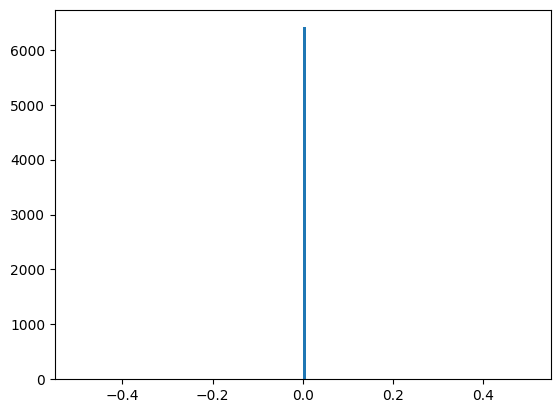

In [87]:
_ = plt.hist(data['F'][744,:], bins=150)

In [76]:
prob_thresh = 0.75

threshcells_bool = data['iscell'][:,0]==1
threshcells_bool[cellstats['prob']<prob_thresh] = 0

threshcells = inds[threshcells_bool]

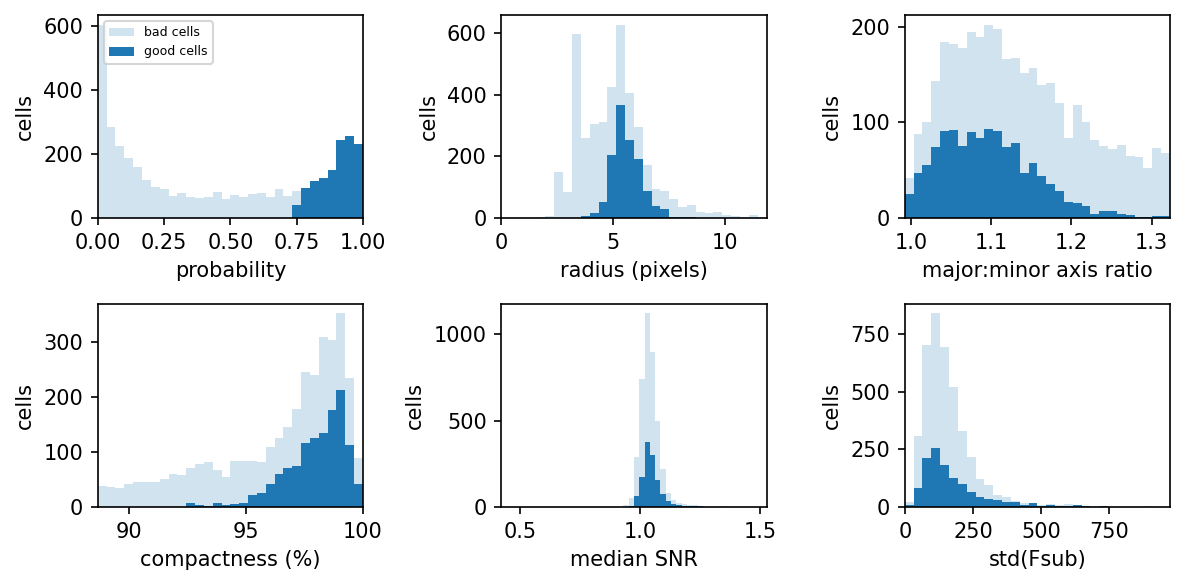

In [90]:
fig, [[prop1,prop2,prop3],[prop4,prop5,prop6]] = plt.subplots(2,3, figsize=(8,4), dpi=150)

cell_id = 0

prop1.hist(cellstats['prob'], bins=np.linspace(0,1,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        alpha=0.2, label='bad cells')
h, _, _ = prop1.hist(cellstats['prob'][threshcells], bins=np.linspace(0,1,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        label='good cells')
# prop1.vlines(cellstats['prob'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#         label='cell {}'.format(cell_id))
prop1.legend(fontsize=6, loc='upper left')
prop1.set_xlim([0,1])
prop1.set_xlabel('probability')
prop1.set_ylabel('cells')

_usemax = np.max(cellstats['rad'][threshcells])+3
prop2.hist(cellstats['rad'], bins=np.linspace(0,_usemax,31),
        histtype='stepfilled', color='tab:blue', linewidth=1,
        alpha=0.2, label='bad cells')
h, _, _ = prop2.hist(cellstats['rad'][threshcells], bins=np.linspace(0,_usemax,31),
            histtype='stepfilled', color='tab:blue', linewidth=1, label='good cells')
# prop2.vlines(cellstats['rad'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#         label='cell {}'.format(cell_id))
prop2.set_xlim([0, _usemax])
prop2.set_ylabel('cells')
prop2.set_xlabel('radius (pixels)')

_usemin = np.min(cellstats['aspect'][threshcells])
_usemax = np.max(cellstats['aspect'][threshcells])
prop3.hist(cellstats['aspect'], bins=np.linspace(_usemin,_usemax,31),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop3.hist(cellstats['aspect'][threshcells], bins=np.linspace(_usemin,_usemax,31),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop3.vlines(cellstats['aspect'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#             label='cell {}'.format(cell_id))
prop3.set_xlim([_usemin, _usemax])
prop3.set_ylabel('cells')
prop3.set_xlabel('major:minor axis ratio')

_usemin = np.min(cellstats['cmpt'][threshcells])
prop4.hist(cellstats['cmpt'], bins=np.linspace(_usemin,100,31), histtype='stepfilled',
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells')
h, _, _ = prop4.hist(cellstats['cmpt'][threshcells], bins=np.linspace(_usemin,100,31),
                    color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop4.vlines(cellstats['cmpt'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#             label='cell {}'.format(cell_id))
prop4.set_xlim([_usemin, 100])
prop4.set_ylabel('cells')
prop4.set_xlabel('compactness (%)')

_usemin = np.nanmin(cellstats['snr'][threshcells])
_usemax = np.nanmax(cellstats['snr'][threshcells])
prop5.hist(cellstats['snr'], bins=np.linspace(_usemin,_usemax,51),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop5.hist(cellstats['snr'][threshcells], bins=np.linspace(_usemin,_usemax,51),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop5.vlines(cellstats['snr'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#                 label='cell {}'.format(cell_id))
prop5.set_xlim([_usemin, _usemax])
prop5.set_ylabel('cells')
prop5.set_xlabel('median SNR')

_usemax = np.max(cellstats['std'][threshcells])
prop6.hist(cellstats['std'], bins=np.linspace(0,_usemax,31),
        color='tab:blue', linewidth=1, alpha=0.2, label='bad cells',
            histtype='stepfilled')
h, _, _ = prop6.hist(cellstats['std'][threshcells], bins=np.linspace(0,_usemax,31),
            color='tab:blue', linewidth=1, label='good cells', histtype='stepfilled')
# prop6.vlines(cellstats['std'][cell_id], 0, np.max(h), color='tab:red', linewidth=1,
#                 label='cell {}'.format(cell_id))
prop6.set_xlim([0, _usemax])
prop6.set_ylabel('cells')
prop6.set_xlabel('std(Fsub)')

fig.tight_layout()